In [181]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium   # conferir se precisa

    # clone repository
    !git clone https://github.com/LucaLemos/UFRPE_AprendizagemReforco
    sys.path.append("/content/UFRPE_AprendizagemReforco")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )


In [182]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path


In [183]:
# Configuração do ambiente
ENV_NAME = "CliffWalking-v0"
env = gym.make(ENV_NAME, render_mode="rgb_array")

In [184]:
# Hiperparâmetros
GAMMA = 0.95  # Fator de desconto
ITERATIONS = 500  # Número de iterações do Fitted Q-Iteration
DATASET_SIZE = 2_000  # Tamanho do conjunto de dados (replay buffer)
BATCH_SIZE = 64  # Tamanho do batch para treinamento da rede neural
LEARNING_RATE = 1e-3  # Taxa de aprendizado para o otimizador

In [185]:
# Parâmetros da estratégia ε-greedy
EPSILON_START = 1.0  # Taxa de exploração inicial
EPSILON_MIN = 0.01  # Taxa de exploração mínima
EPSILON_DECAY = 0.998  # Decaimento da taxa de exploração

In [186]:
# Passo 1: Definir a Rede Neural para Aproximação da Função Q
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Camada fully connected 1
        self.fc2 = nn.Linear(64, 64)         # Camada fully connected 2
        self.fc3 = nn.Linear(64, output_dim) # Camada de saída

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Função de ativação ReLU
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Inicializar a rede neural
input_dim = env.observation_space.n  # Número de estados
output_dim = env.action_space.n      # Número de ações
q_network = QNetwork(input_dim, output_dim)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()  # Função de perda: Erro Quadrático Médio

# Função para converter estados em tensores one-hot
def to_one_hot(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot)

In [187]:
# Passo 2: Coletar um conjunto fixo de transições (Replay Buffer)
replay_buffer = deque(maxlen=DATASET_SIZE)
epsilon = EPSILON_START  # Inicializa a taxa de exploração

contador = 0
for _ in range(DATASET_SIZE):
    state, _ = env.reset()  # Reseta o ambiente para um estado inicial
    done = False
    print(contador)
    contador += 1
    while not done:
        # Estratégia ε-greedy: escolhe uma ação aleatória ou a melhor ação conhecida
        if random.random() < epsilon:
            action = env.action_space.sample()  # Exploração: ação aleatória
        else:
            state_tensor = to_one_hot(state, input_dim).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = torch.argmax(q_values).item()  # Exploração: melhor ação conhecida

        # Executa a ação no ambiente
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Armazena a transição no replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state  # Atualiza o estado atual

    # Decaimento da taxa de exploração
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [188]:
# Passo 3: Definir a função evaluate_policy e extract_policy
max_steps=1000000
def evaluate_policy(env, policy, episodes=100):
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0
        while not done and steps < max_steps:
            action = policy[state]  # Segue a política aprendida
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
            steps += 1
        total_rewards.append(episode_reward)
        if episode % 50 == 0:
            print(f"Episódio {episode + 1}, Recompensa: {episode_reward}, Passos: {steps}")
    return np.mean(total_rewards)

def extract_policy(q_network, num_states):
    policy = []
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor)
        action = torch.argmax(q_values).item()
        policy.append(action)
    return policy

In [189]:
# Passo 4: Aplicar Fitted Q-Iteration (Offline RL)
# Listas para armazenar métricas
losses = []
success_rates = []
q_values_means = []
rewards_variances = []

for iteration in range(ITERATIONS):
    # Amostrar um batch de transições do replay buffer
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Converter estados e próximos estados para one-hot
    states = torch.stack([to_one_hot(s, input_dim) for s in states])
    next_states = torch.stack([to_one_hot(ns, input_dim) for ns in next_states])
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    # Calcular os valores Q atuais
    current_q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

    # Calcular os valores Q alvo (target)
    with torch.no_grad():
        next_q_values = q_network(next_states).max(1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Calcular a perda e atualizar a rede
    loss = criterion(current_q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Métricas adicionais
    q_values_means.append(current_q_values.mean().item())  # Valor Q médio
    rewards_variances.append(torch.var(rewards).item())   # Variância das recompensas

    # Avaliação periódica da política
    if iteration % 25 == 0:  # Avaliar a cada 25 iterações
        success_rate = evaluate_policy(env, extract_policy(q_network, input_dim), episodes=100)  # 500 episódios
        losses.append(loss.item())
        success_rates.append(success_rate)
        print(f"Iteração {iteration}, Perda: {loss.item():.4f}, Taxa de Sucesso: {success_rate:.2f}%")

Episódio 1, Recompensa: -100000000, Passos: 1000000
Episódio 51, Recompensa: -100000000, Passos: 1000000
Iteração 0, Perda: 3282.0862, Taxa de Sucesso: -100000000.00%
Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Iteração 25, Perda: 4350.5322, Taxa de Sucesso: -1000000.00%
Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Iteração 50, Perda: 4452.1714, Taxa de Sucesso: -1000000.00%
Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Iteração 75, Perda: 4787.7549, Taxa de Sucesso: -1000000.00%
Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Iteração 100, Perda: 3666.4004, Taxa de Sucesso: -1000000.00%
Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Iteração 125, Perda: 2908.2546, Taxa de Sucesso: -1000000.00%
Episódio 1, Recompens

In [190]:
# Passo 5: Avaliar a Política Aprendida
optimal_policy = extract_policy(q_network, input_dim)

success_rate = evaluate_policy(env, optimal_policy)  # 500 episódios
print(f"Taxa de sucesso da política aprendida: {success_rate:.2f}%")

Episódio 1, Recompensa: -1000000, Passos: 1000000
Episódio 51, Recompensa: -1000000, Passos: 1000000
Taxa de sucesso da política aprendida: -1000000.00%


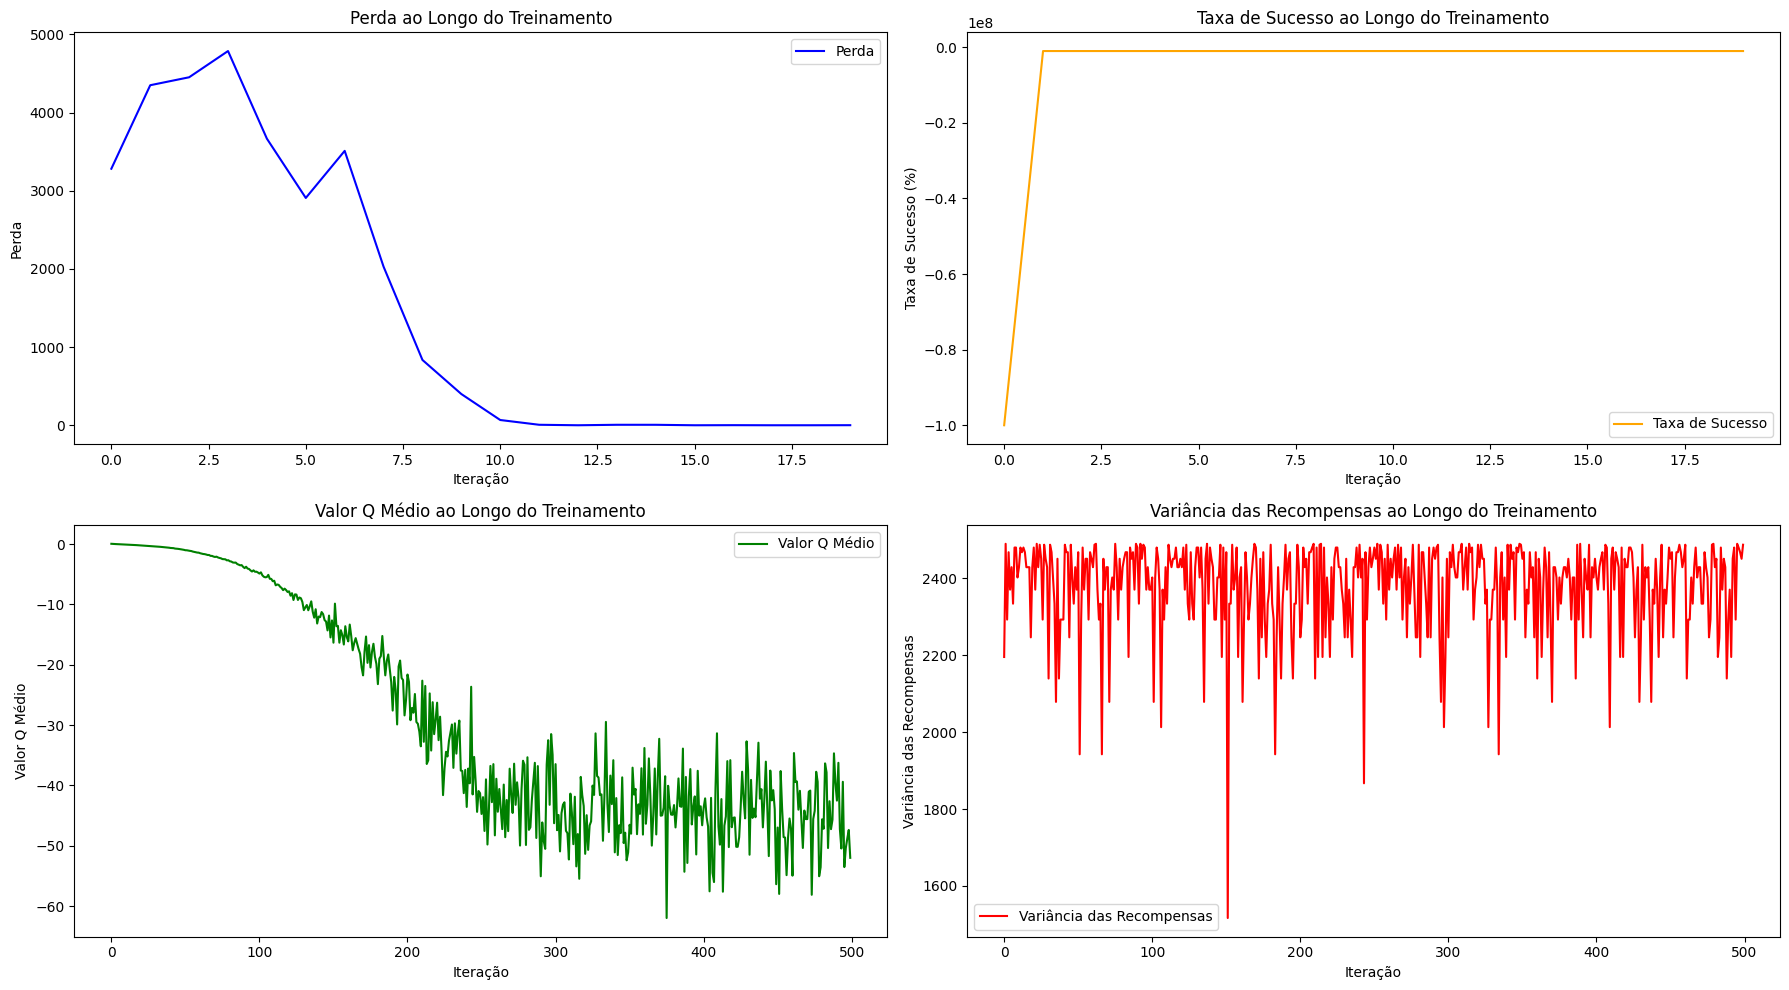

In [191]:
# Passo 6: Visualização Gráfica
plt.figure(figsize=(18, 10))

# Gráfico da Perda
plt.subplot(2, 2, 1)
plt.plot(losses, label="Perda", color="blue")
plt.xlabel("Iteração")
plt.ylabel("Perda")
plt.title("Perda ao Longo do Treinamento")
plt.legend()

# Gráfico da Taxa de Sucesso
plt.subplot(2, 2, 2)
plt.plot(success_rates, label="Taxa de Sucesso", color="orange")
plt.xlabel("Iteração")
plt.ylabel("Taxa de Sucesso (%)")
plt.title("Taxa de Sucesso ao Longo do Treinamento")
plt.legend()

# Gráfico do Valor Q Médio
plt.subplot(2, 2, 3)
plt.plot(q_values_means, label="Valor Q Médio", color="green")
plt.xlabel("Iteração")
plt.ylabel("Valor Q Médio")
plt.title("Valor Q Médio ao Longo do Treinamento")
plt.legend()

# Gráfico da Variância das Recompensas
plt.subplot(2, 2, 4)
plt.plot(rewards_variances, label="Variância das Recompensas", color="red")
plt.xlabel("Iteração")
plt.ylabel("Variância das Recompensas")
plt.title("Variância das Recompensas ao Longo do Treinamento")
plt.legend()

plt.tight_layout()
plt.show()

In [192]:
# Passo 7: Implementar Q-Iteration (Programação Dinâmica)
def q_iteration(env, gamma=GAMMA, iterations=1000):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))  # Tabela Q inicializada com zeros

    for _ in range(iterations):
        Q_prev = Q.copy()
        for state in range(num_states):
            for action in range(num_actions):
                # Pega todas as transições possíveis para o par (state, action)
                transitions = env.unwrapped.P[state][action]
                q_value = 0
                for prob, next_state, reward, done in transitions:
                    # Atualiza o valor Q usando a equação de Bellman
                    q_value += prob * (reward + gamma * np.max(Q_prev[next_state]))
                Q[state][action] = q_value

        # Verifica convergência
        if np.max(np.abs(Q - Q_prev)) < 1e-6:
            break

    return Q

In [193]:
# Executar Q-Iteration
Q_table = q_iteration(env)
print("Tabela Q ótima calculada por Q-Iteration:")
print(Q_table)

# Extrair política ótima da tabela Q
optimal_policy_q_iteration = np.argmax(Q_table, axis=1)
print("\nPolítica ótima calculada por Q-Iteration:")
print(optimal_policy_q_iteration)

# Avaliar a política ótima do Q-Iteration
success_rate_q_iteration = evaluate_policy(env, optimal_policy_q_iteration) * 100
print(f"\nTaxa de sucesso da política aprendida por Q-Iteration: {success_rate_q_iteration:.2f}%")

Tabela Q ótima calculada por Q-Iteration:
[[ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.99998163  -19.99998163  -19.99998163  -19.99998163]
 [ -19.9999816

In [194]:
# Gravar um vídeo da política treinada
record_video_qtable(ENV_NAME, Q_table, episodes=2, folder='videos/', prefix='q-iteration')

display_videos_from_path('videos/', prefix='q-iteration')

C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Downloads_D\Faculdade\git\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
